In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import functional as F
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import random

import requests
from io import BytesIO

In [3]:
class Conf:
    max_power_db = -5
    min_power_db = -28

    batch_size = 8

    d = 21
    receptive_field = 2 * d + 1
    image_hw = 10 * receptive_field
    dimensions = (image_hw, image_hw, 3)

    patch_size = receptive_field
    stride = 3 * receptive_field // 4

In [4]:
class DnCNN(nn.Module):
    def __init__(self, in_channels=3, depth=17, num_filters=64):
        super(DnCNN, self).__init__()
        
        layers = []
        
        # First layer: Conv + ReLU
        layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))
        
        # Middle layers: Conv + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.ReLU(inplace=True))
        
        # Last layer: Conv (no activation or normalization)
        layers.append(nn.Conv2d(num_filters, in_channels, kernel_size=3, padding=1, bias=False))

        layers.append(nn.Sigmoid())
        
        self.dncnn = nn.Sequential(*layers)
    
    def forward(self, x):
        return x - self.dncnn(x)

In [5]:
model = DnCNN(in_channels=3, depth=Conf.d)
model.load_state_dict(torch.load('/kaggle/input/image-denoising/DnCNN.pth', map_location=torch.device('cpu')))

/tmp/ipykernel_24/4206484534.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/image-denoising/DnCNN.pth', map_location=tor

<All keys matched successfully>

In [6]:
def gaussian_noise(power_db, dim):
    power_linear = 10 ** (power_db / 10)
    std_dev = np.sqrt(power_linear)
    noise_image = np.random.normal(loc=0, scale=std_dev, size=dim)

    clamped_noise = np.clip(noise_image, 0, 1)
    
    return clamped_noise

In [13]:
def denoise_image(model, image_path, is_url=False, add_noise=True):
    if is_url:
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)

    if add_noise:
        noise = torch.from_numpy(gaussian_noise(-14.5, image_tensor.shape)).float()
        noisy_image_tensor = torch.clamp(image_tensor + noise, 0, 1)
    else:
        noisy_image_tensor = image_tensor.clone()

    device = next(model.parameters()).device
    noisy_image_tensor = noisy_image_tensor.to(device)

    def extract_patches(img_tensor, patch_size, stride):
        C, H, W = img_tensor.shape[1], img_tensor.shape[2], img_tensor.shape[3]
        patches = []
        positions = []
        for i in range(0, H, stride):
            for j in range(0, W, stride):
                end_i = min(i + patch_size, H)
                end_j = min(j + patch_size, W)
                patch = img_tensor[:, :, i:end_i, j:end_j]
                patches.append(patch)
                positions.append((i, j))
        return patches, positions

    patches, positions = extract_patches(noisy_image_tensor, Conf.patch_size, Conf.stride)

    denoised_patches = []
    model.eval()
    with torch.no_grad():
        for patch in patches:
            predicted_noise = model(patch)
            denoised_patch = predicted_noise
            denoised_patches.append(torch.clamp(denoised_patch, 0, 1))

    C, H, W = noisy_image_tensor.shape[1], noisy_image_tensor.shape[2], noisy_image_tensor.shape[3]
    reconstructed = torch.zeros_like(noisy_image_tensor)
    patch_count = torch.zeros((1, 1, H, W), device=device)

    patch_size = Conf.patch_size
    for (i, j), dp in zip(positions, denoised_patches):
        reconstructed[:, :, i:i+patch_size, j:j+patch_size] += dp
        patch_count[:, :, i:i+patch_size, j:j+patch_size] += 1

    safe_patch_count = torch.where(patch_count == 0, torch.ones_like(patch_count), patch_count)
    denoised_image_tensor = reconstructed / safe_patch_count
    denoised_image_tensor = denoised_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

    noisy_image_display = noisy_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(noisy_image_display)
    ax[0].set_title("Noisy Image")
    ax[0].axis('off')

    ax[1].imshow(denoised_image_tensor)
    ax[1].set_title("Denoised Image")
    ax[1].axis('off')

    ax[2].imshow(image_tensor.squeeze(0).permute(1, 2, 0))
    ax[2].set_title("Original Image")
    ax[2].axis('off')

    plt.show()

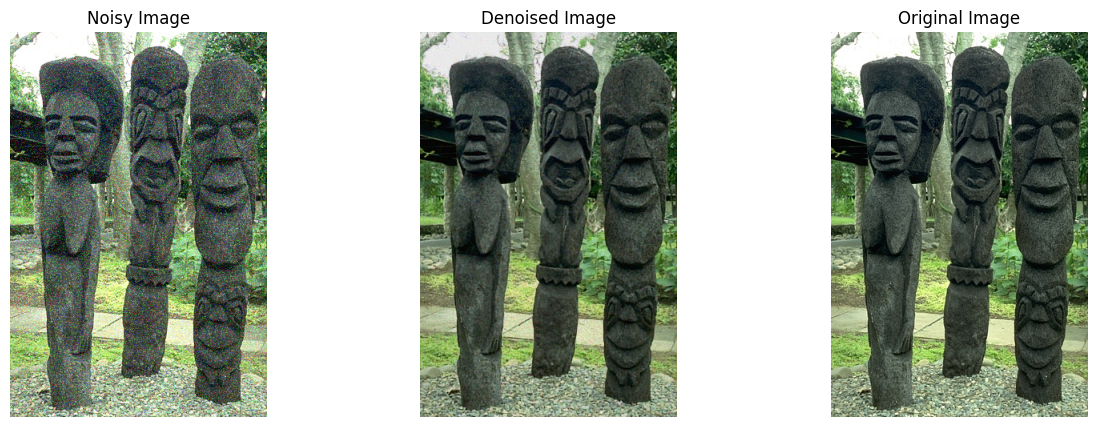

In [14]:
denoise_image(model, '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/val/101085.jpg', is_url=False, add_noise=True)